In [45]:
import wandb

# Initialize API (make sure you're logged in or set the API key)
wandb.login()

# Replace with your entity, project, and run ID
api = wandb.Api()

# Get all runs of the project that didn't crash
runs = api.runs("rl-sunflower/tabpfn-time-series", filters={"state": "finished", "summary_metrics.constraint": "4h16c"})


In [46]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd

def fetch_run_data(run):
    history = run.history()
    
    if len(history) > 1:
        # get the first row
        history = history.iloc[-1:]
    return history

# time the following code
import time
start = time.time()

all_runs_data = []
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust 'max_workers' based on your network conditions
    futures = [executor.submit(fetch_run_data, run) for run in runs]
    for future in tqdm(as_completed(futures), total=len(futures)):
        all_runs_data.append(future.result())

df_all_runs = pd.concat(all_runs_data)
print("df_all_runs.shape:", df_all_runs.shape)

print(f"Time taken: {time.time() - start:.2f} seconds")

100%|██████████| 68/68 [00:03<00:00, 17.81it/s]

df_all_runs.shape: (68, 27)
Time taken: 4.68 seconds


In [47]:
# Check if all history entries (columns = ['task', 'framework']) are unique
df_all_runs.duplicated(subset=['task', 'framework']).sum()

17

In [48]:
# Preprocess data (convert to float, NaN value -> inf)
numerical_cols = ['mase', 'wql', 'duration', 'result']
for col in numerical_cols:
    df_all_runs[col] = df_all_runs[col].astype(float)
    df_all_runs[col] = df_all_runs[col].fillna(float('inf'))

In [49]:
# tabpfn_runs = df_all_runs[df_all_runs["framework"] == "TabPFN"]
df_sorted = df_all_runs.sort_values(by='task')

# drop index
df_sorted.reset_index(drop=True, inplace=True)

# Plotting

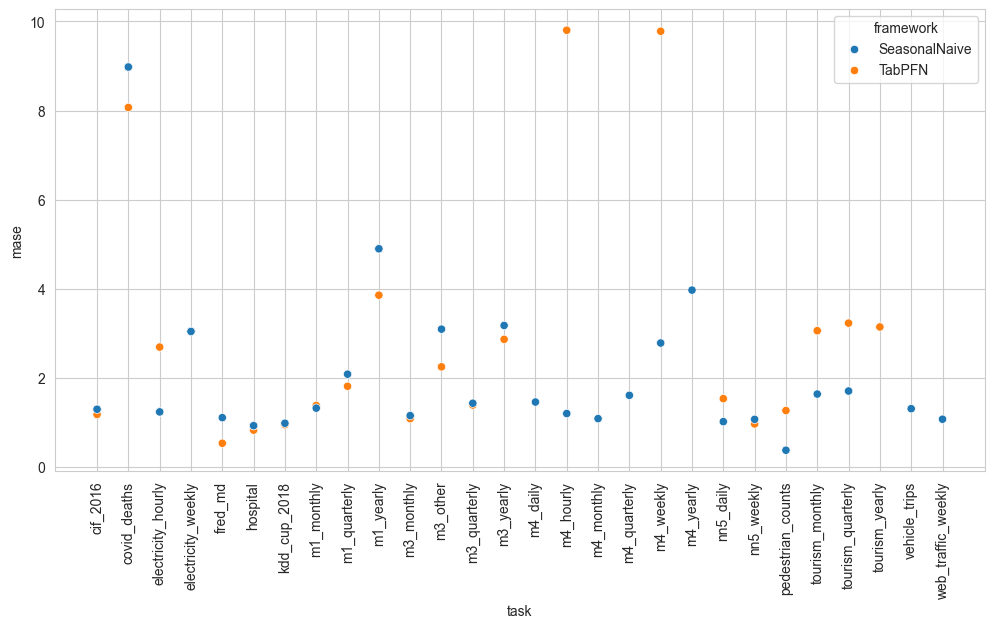

In [50]:
# Scatter plot of <mase of each framework> against <tasks>
#  - y-axis: mase
#  - x-axis: tasks
#  - color: framework

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sorted, x='task', y='mase', hue='framework')
plt.xticks(rotation=90)
plt.show()

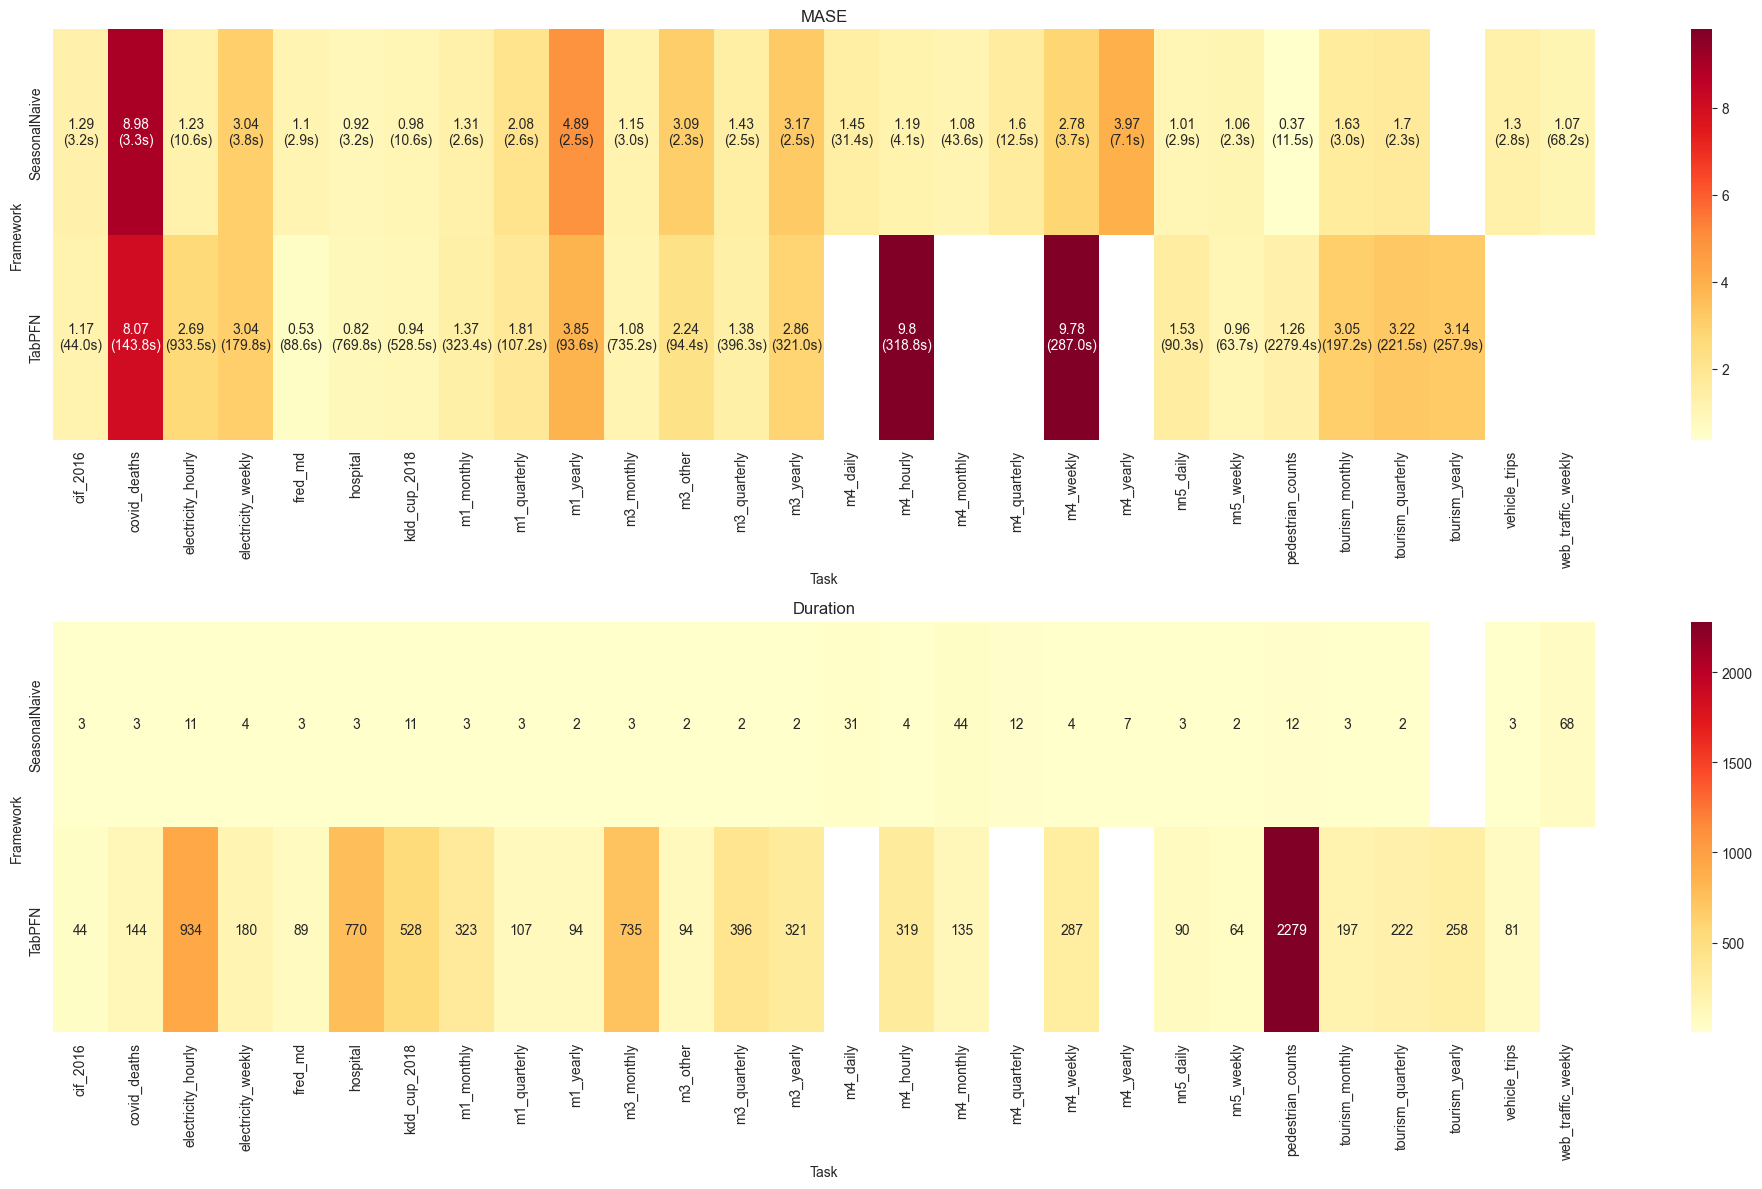

In [51]:
# Plot the same data with heatmap (mase as color)
#  - y-axis: frameworks
#  - x-axis: tasks

# Get relevant columns only
df_rel = df_sorted[['framework', 'task', 'mase', 'wql', 'duration']]
df_rel = df_rel.drop_duplicates(subset=["framework", "task"], keep='first')

# Pivot the data
df_mase_pivot = df_rel.pivot(index='framework', columns='task', values='mase').astype(float).replace(float('inf'), float('nan'))

# Customized annotation (each cell shuold be value of mase and total duration as a subtext)
df_duration = df_rel.pivot(index='framework', columns='task', values='duration').astype(float)
df_mase_annot = df_mase_pivot.round(2).astype(str) + f"\n(" + df_duration.astype(str) + "s)"

# Generate two heatmaps, in one figure (MASE and duration)
fig, axs = plt.subplots(2, 1, figsize=(20, 12))
sns.heatmap(df_mase_pivot, cmap='YlOrRd', annot=df_mase_annot, fmt="s", ax=axs[0])
axs[0].set_title("MASE")
axs[0].set_ylabel("Framework")
axs[0].set_xlabel("Task")
axs[0].grid(False)

# Plot duration heatmap
sns.heatmap(df_duration, cmap='YlOrRd', annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("Duration")
axs[1].set_ylabel("Framework")
axs[1].set_xlabel("Task")
axs[1].grid(False)

plt.tight_layout()
plt.show()


